# Process Spatio-Spectral Images

##### initialize the analysis by inputting the filename and number of rows in scan

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy import optimize
import datetime

In [2]:
def initialize(fileNameIn,scanRange):
    '''this function reads the file at fileName into a pandas dataframe and creates a variable for the scan range'''
    from scipy import optimize
    global scanSize
    global data
    global fileName
    fileName = fileNameIn
    #define variable for number of pixels in scan
    scanSize = scanRange
    from matplotlib import cm
    #read in csv file to create pandas dataframe
    dataTrans = pd.read_csv(fileName, header = None, sep=',')
    #transpose data to make pixel information contained in the columns
    data = dataTrans.transpose()
    fileName = fileNameIn[:-4]
    return print('data loaded')

In [3]:
initialize('0927184.csv',64)

data loaded


##### separate data into forward and backward scans

In [4]:
def separateData():
    '''separates data into python arrays of forward and backward AFM scans called forward and reverse
    with rows of wavelengths and intensities for each pixel. 
    Also creates a list called Wavelength which contains the wavelength values and arrays called 
    forwardInt and reverseInt which only have the intensities.'''
    global forwardData
    global revData
    global forward
    global reverse
    global forwardInt
    global reverseInt
    global wavelength
    global scanSize
    #define scan range
    numPixels = scanSize
    #make new arrays to hold the forward and reverse data
    forwardData = data.copy()
    revData = data.copy()
    #separate data from forward and reverse scans
    for j in range(0,numPixels*2):
        forwardData = forwardData.drop(j+(numPixels*2),1)
        revData = revData.drop(j,1)
    for i in range(1, numPixels-1):
        for j in range(0,numPixels*2):
            forwardData = forwardData.drop(j+4*i*numPixels+(numPixels*2),1)
            revData = revData.drop(j+(4*i*numPixels),1)
    print('done dropping')
    #make rows contain each pixel's data for easier plotting
    forwardT = forwardData.transpose()
    revT = revData.transpose()
    #convert back to a normal numpy array from the pandas dataframe
    forward = forwardT.values
    reverse = revT.values
    #create wavelength list 
    wavelength = forward[0].copy()
    #create new arrays without wavelength lists
    forwardInt = forward.copy()
    reverseInt = reverse.copy()
    for i in range(0,scanSize*scanSize):
        forwardInt = np.delete(forwardInt, (i), axis=0)
        reverseInt = np.delete(reverseInt, (i), axis=0)
    #export these to csv for later use
    fwdTemp = pd.DataFrame(forwardInt)
    fwdTemp.to_csv(fileName + '_forwardInt.csv')
    revTemp = pd.DataFrame(reverseInt)
    revTemp.to_csv(fileName + '_reverseInt.csv')
    wlTemp = pd.DataFrame(wavelength)
    wlTemp.to_csv(fileName + '_wavelength.csv')
    print('your data is stored in arrays of size:\n')
    return forwardInt.shape

In [5]:
separateData()

done dropping
your data is stored in arrays of size:



(4224, 1600)

##### plot a few example spectra

In [6]:
def plotSpectra():
    '''plots spectra for forward and reverse scans. Subset of images can be plotted 
    by increasing variable indexStep.'''
    global scanSize
    indexStep = 200
    #plot forward scan spectra 
    for i in range(1,scanSize*scanSize,indexStep):
        plt.plot(wavelength,forward[i])
    plt.show()
    #plot backward scan spectra
    for i in range(1,scanSize*scanSize,indexStep):
        plt.plot(wavelength,reverse[i])
    plt.show()

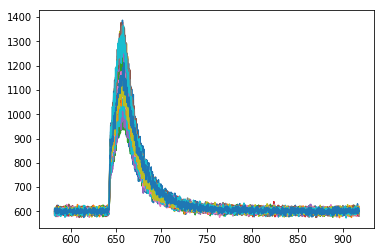

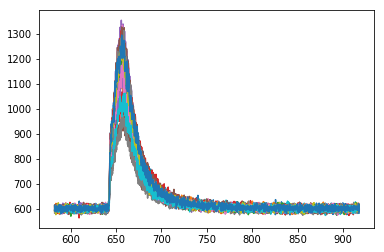

In [7]:
plotSpectra()

##### plot integrated intensities at each point

In [8]:
def plotInt():
    '''generates heat map of integrated spectral intensities at each pixel for forward and reverse scans'''
    global forImage
    global revImage
    global forNorm
    global revNorm
    global scanSize
    %matplotlib inline
    forImage = np.empty([scanSize,scanSize])
    revImage = np.empty([scanSize,scanSize])
    from PIL import Image
    for i in range(0,scanSize):
        for j in range(0,scanSize):
            forImage[i][j]=sum(forwardInt[j+i*scanSize])
            revImage[i][-j-1]=sum(reverseInt[j+i*scanSize])
    #normalize forward and reverse images to an intensity of 1
    forNorm = forImage/np.amax(forImage)
    revNorm = revImage/np.amax(forImage)
    # Make forward scan image
    fig, ax = plt.subplots()
    cax = ax.imshow(forNorm, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Forward Scan')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    #make reverse scan image
    fig, ax = plt.subplots()
    cax = ax.imshow(revNorm, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Reverse Scan')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax) #, ticks=[0, np.amax(forImage)]
    #cbar.ax.set_yticklabels(['0', '> 1'])  # vertically oriented colorbar

    plt.show()

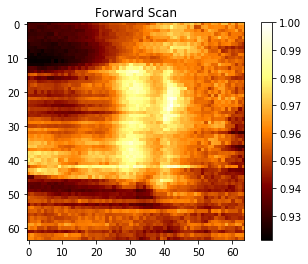

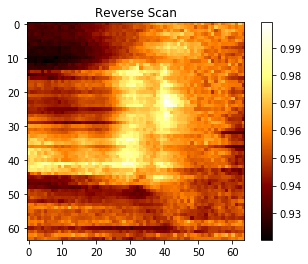

In [9]:
plotInt()

##### plot example spectra and set fit range

In [10]:
def setRange(specNum,rangeLow,rangeHigh):
    '''plots spectrum number specNum in range rangeLow to rangeHigh'''
    global x_data
    global y_data
    global rangeH
    global rangeL
    %matplotlib inline
    rangeH = rangeHigh
    rangeL = rangeLow
    x_data = wavelength[rangeLow:rangeHigh]
    y_data = forwardInt[specNum][rangeLow:rangeHigh]
    # And plot it
    plt.figure(figsize=(6, 4))
    return plt.scatter(x_data, y_data)

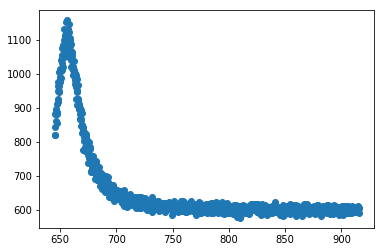

In [11]:
setRange(4000, 300, 1590)

##### fit example spectrum from above and set fit params (p0) and bounds

In [12]:
def test_func(x, a, b, c, g):
    return a/((x-b)**2 + c**2) +  + g;

In [30]:
def fitSpectrum():
    '''fits to one lorentzian with params: int, position, width, offset.'''
    global x_data
    global y_data
    global initParams
    global paramBounds
    global params
    initParams=[10000, 655, 30, 590]
    paramBounds=([0, 600, 1, 400],[10000000, 700, 100, 700])
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
    print(params)
    plt.figure(figsize=(6, 4))
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_data, test_func(x_data, params[0], params[1], params[2], params[3]),
            label='Fitted function')
    plt.legend(loc='best')
    return plt.show()

In [34]:
type(initParams)

list

[8.28695021e+04 6.56808311e+02 1.28924308e+01 6.00817022e+02]


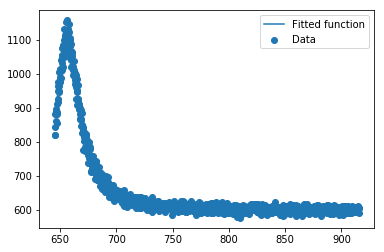

In [32]:
fitSpectrum()

##### fit and plot subset of spectra defined by indexStep variable, output fit params to array testParams

In [25]:
def fitSubset(indexStep,rangeLow,rangeHigh):
    global testParams
    testParams = []
    #loop that fits and plots test spectra
    for i in range(0,len(forwardInt)-scanSize, indexStep):
        #print spectrum number
        print(i)
        #cycle through spectra in specified range
        y_data = forwardInt[i][rangeLow:rangeHigh]
        #fitting to test_func
        params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
        #plot data and fit
        plt.figure(figsize=(6, 4))
        plt.scatter(x_data, y_data, label='Data')
        plt.plot(x_data, test_func(x_data, params[0], params[1], params[2], params[3]),
                 label='Fitted function')
        plt.legend(loc='best')
        testParams.append(params)
        plt.show()

0


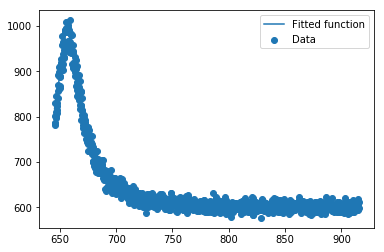

200


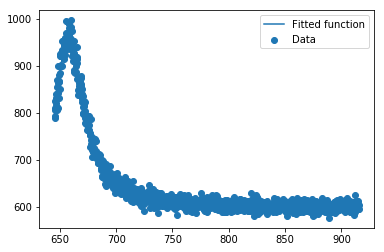

400


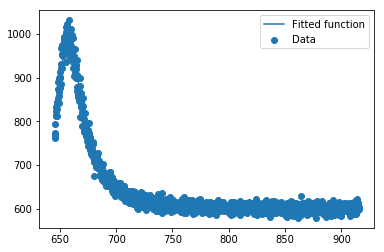

600


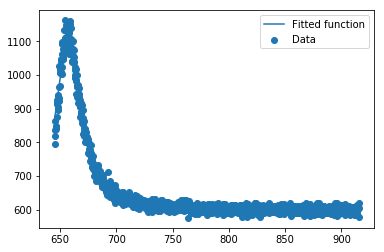

800


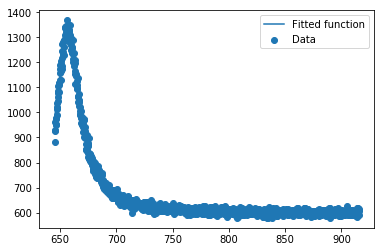

1000


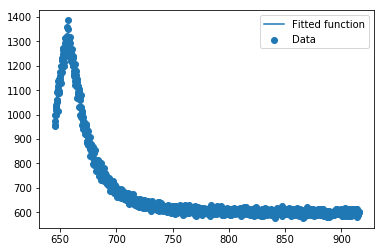

1200


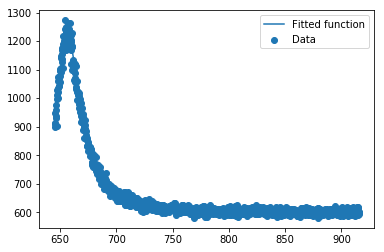

1400


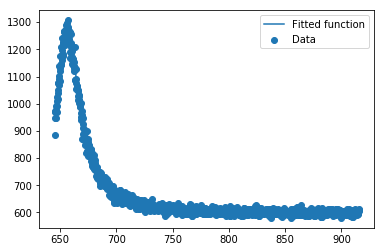

1600


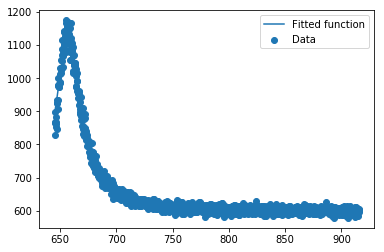

1800


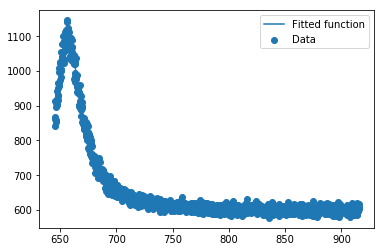

2000


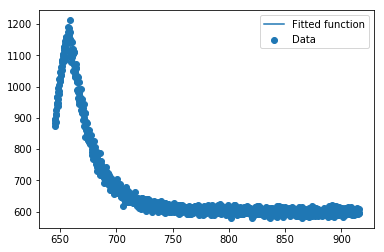

2200


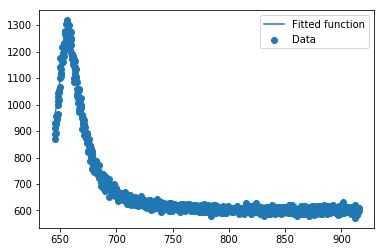

2400


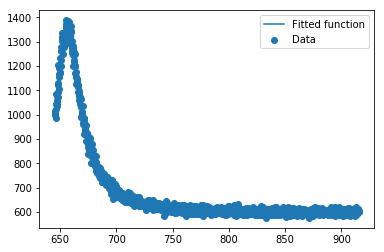

2600


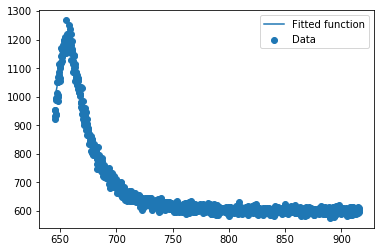

2800


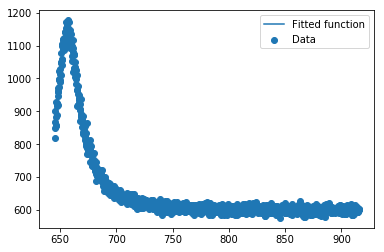

3000


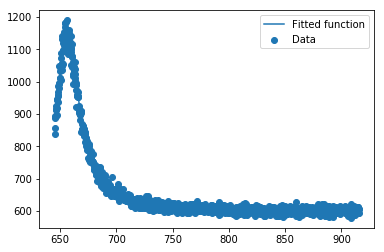

3200


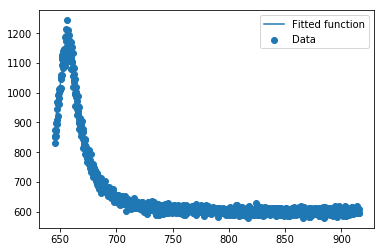

3400


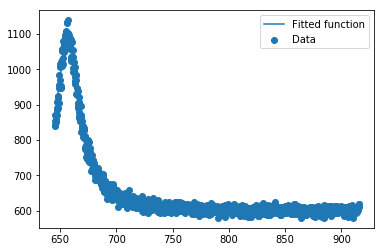

3600


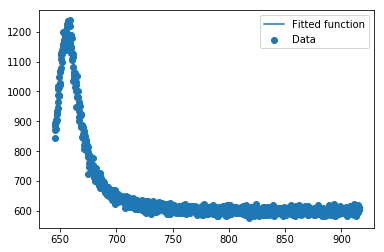

3800


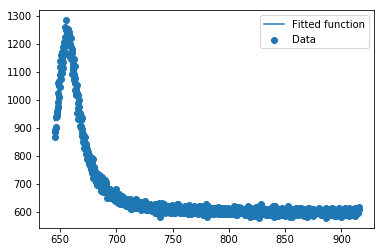

4000


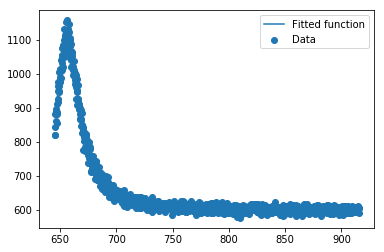

In [26]:
fitSubset(200,rangeL, rangeH)

##### fit all spectra, output fit params to array allParams. Fitting errors result in parameters of '0' value and the relevant spectrum number is printed.

In [17]:
def fitSpectraFor(rangeLow,rangeHigh):
    '''fit all forward spectra to test_func and store fit params in rows of allParamsFor array'''
    global allParamsFor
    global wavelength
    allParamsFor = []
    x_data = wavelength[rangeLow:rangeHigh]
    for i in range(0,len(forwardInt)):
        try:
            y_data = forwardInt[i][rangeLow:rangeHigh]
            params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
            allParamsFor.append(params)
        except RuntimeError:
            allParamsFor.append([0,0,0,0,0,0,0])
            print(i)
    return print('finished fitting!')

In [18]:
fitSpectraFor(rangeL, rangeH)

finished fitting!


##### Create images from fit params for the intensity, position, and width of peaks for forward scan. 

In [19]:
def plotFitFor(dataName):
    '''generates heat map of fit parameters at each pixel for forward scan and saves each image as a png.'''
    global forPos
    global forInt
    global forWid
    global allParamsFor
    %matplotlib inline
    forInt = np.empty([scanSize,scanSize])
    forPos = np.empty([scanSize,scanSize])
    forWid = np.empty([scanSize,scanSize])
    from PIL import Image
    for i in range(0,scanSize):
        for j in range(0,scanSize):
            forInt[i][j]=allParamsFor[j+i*scanSize][0]
            forPos[i][j]=allParamsFor[j+i*scanSize][1]
            forWid[i][j]=allParamsFor[j+i*scanSize][2]
    #normalize forward and reverse intensities to an intensity of 1
    forIntNorm = forInt/np.amax(forInt)
    #revNorm = revImage/np.amax(forImage)
    # Make forward intensity images
    fig, ax = plt.subplots()
    cax = ax.imshow(forIntNorm, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Intensity')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    forIntStr = 'spectra/forInt'+ fileName + '_' + dataName +'.png'
    plt.savefig(forIntStr)
    #make forward peak position image
    fig, ax = plt.subplots()
    cax = ax.imshow(forPos, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Peak Position')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    forPosStr = 'spectra/forPos'+ fileName + '_' + dataName +'.png'
    plt.savefig(forPosStr)
    #make forward peak width image
    fig, ax = plt.subplots()
    cax = ax.imshow(forWid, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Peak Width')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    forWidStr = 'spectra/forWid'+ fileName + '_' + dataName +'.png'
    plt.savefig(forWidStr)
    plt.show()

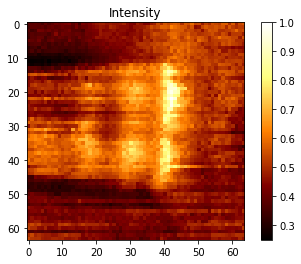

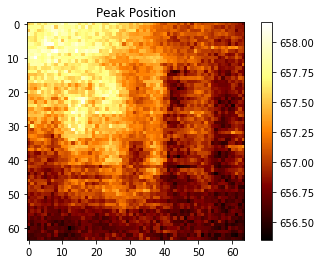

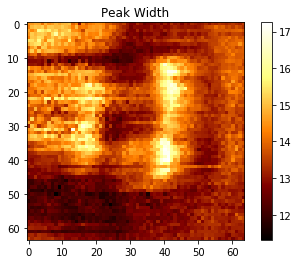

In [20]:
plotFitFor(str(datetime.datetime.now().date()))

In [21]:
def fitSpectraRev(rangeLow,rangeHigh):
    '''fit all reverse spectra to test_func and store fit params in rows of allParamsFor array'''
    global allParamsRev
    global wavelength
    allParamsRev = []
    x_data = wavelength[rangeLow:rangeHigh]
    for i in range(0,len(reverseInt)):
        try:
            y_data = reverseInt[i][rangeLow:rangeHigh]
            params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
            allParamsRev.append(params)
        except RuntimeError:
            allParamsRev.append([0,0,0,0,0,0,0])
            print(i)
    return print('finished fitting!')

In [22]:
fitSpectraRev(rangeL, rangeH)

finished fitting!


In [23]:
def plotFitRev(dataName):
    '''generates heat map of fit parameters at each pixel for reverse scan and saves each image as a png.'''
    global revPos
    global revInt
    global revWid
    global revIntNorm
    %matplotlib inline
    revInt = np.empty([scanSize,scanSize])
    revPos = np.empty([scanSize,scanSize])
    revWid = np.empty([scanSize,scanSize])
    from PIL import Image
    for i in range(0,scanSize):
        for j in range(0,scanSize):
            revInt[i][-j-1]=allParamsRev[j+i*scanSize][0]
            revPos[i][-j-1]=allParamsRev[j+i*scanSize][1]
            revWid[i][-j-1]=allParamsRev[j+i*scanSize][2]
    #normalize reverse and reverse intensities to an intensity of 1
    revIntNorm = revInt/np.amax(forInt)
    # Make reverse intensity image
    fig, ax = plt.subplots()
    cax = ax.imshow(revIntNorm, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Intensity')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    revIntStr = 'spectra/revInt'+ fileName + '_' + dataName +'.png'
    plt.savefig(revIntStr)
    #make reverse peak position image
    fig, ax = plt.subplots()
    cax = ax.imshow(forPos, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Peak Position')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    revPosStr = 'spectra/revPos'+ fileName + '_' + dataName +'.png'
    plt.savefig(revPosStr)
    #make forward peak width image
    fig, ax = plt.subplots()
    cax = ax.imshow(revWid, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Peak Width')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    revWidStr = 'spectra/revWid'+ fileName + '_' + dataName +'.png'
    plt.savefig(revWidStr)
    plt.show()

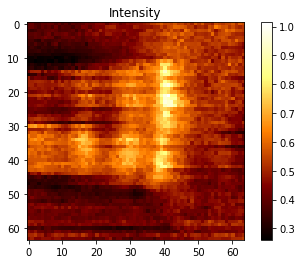

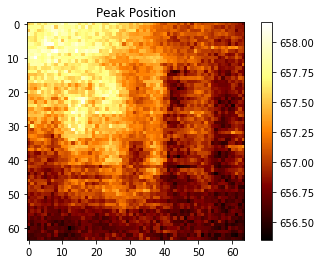

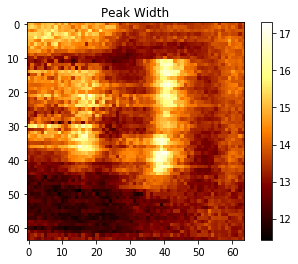

In [24]:
plotFitRev(str(datetime.datetime.now().date()))